Epoch 10/50, Loss: 5.292398782330565e-05
Epoch 20/50, Loss: 3.394848135940265e-06
Epoch 30/50, Loss: 1.2066035424140864e-06
Epoch 40/50, Loss: 1.0895050763792824e-05
Epoch 50/50, Loss: 7.560210633528186e-06
Epoch 10/50, Loss: 3.34805590682663e-05
Epoch 20/50, Loss: 6.135948933660984e-05
Epoch 30/50, Loss: 1.2528565093816724e-05
Epoch 40/50, Loss: 1.616699228179641e-05
Epoch 50/50, Loss: 2.63557922153268e-05
Epoch 10/50, Loss: 0.00014932200429029763
Epoch 20/50, Loss: 1.4415154510061257e-06
Epoch 30/50, Loss: 1.1235462807235308e-05
Epoch 40/50, Loss: 3.187311904184753e-06
Epoch 50/50, Loss: 3.692176687764004e-05
Epoch 10/50, Loss: 6.496131391031668e-05
Epoch 20/50, Loss: 3.2216183171840385e-05
Epoch 30/50, Loss: 1.4241359167499468e-05
Epoch 40/50, Loss: 9.768781637831125e-06
Epoch 50/50, Loss: 4.220615664962679e-05
Epoch 10/50, Loss: 2.858913467207458e-05
Epoch 20/50, Loss: 2.7752650566981174e-05
Epoch 30/50, Loss: 8.538575457350817e-06
Epoch 40/50, Loss: 6.867730007797945e-06
Epoch 50/

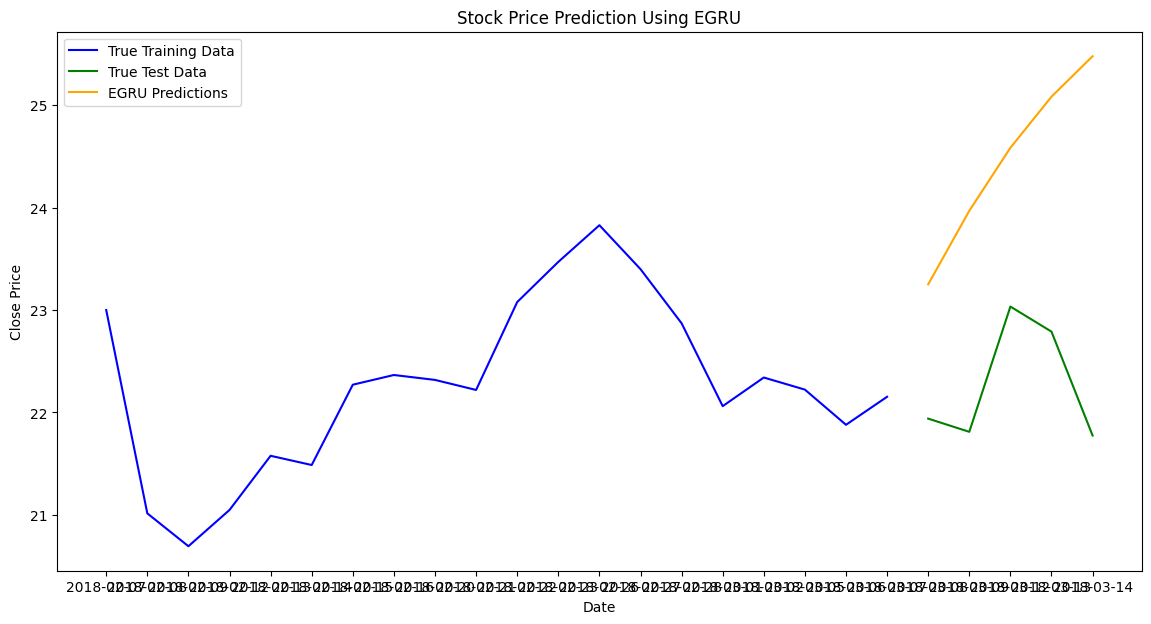

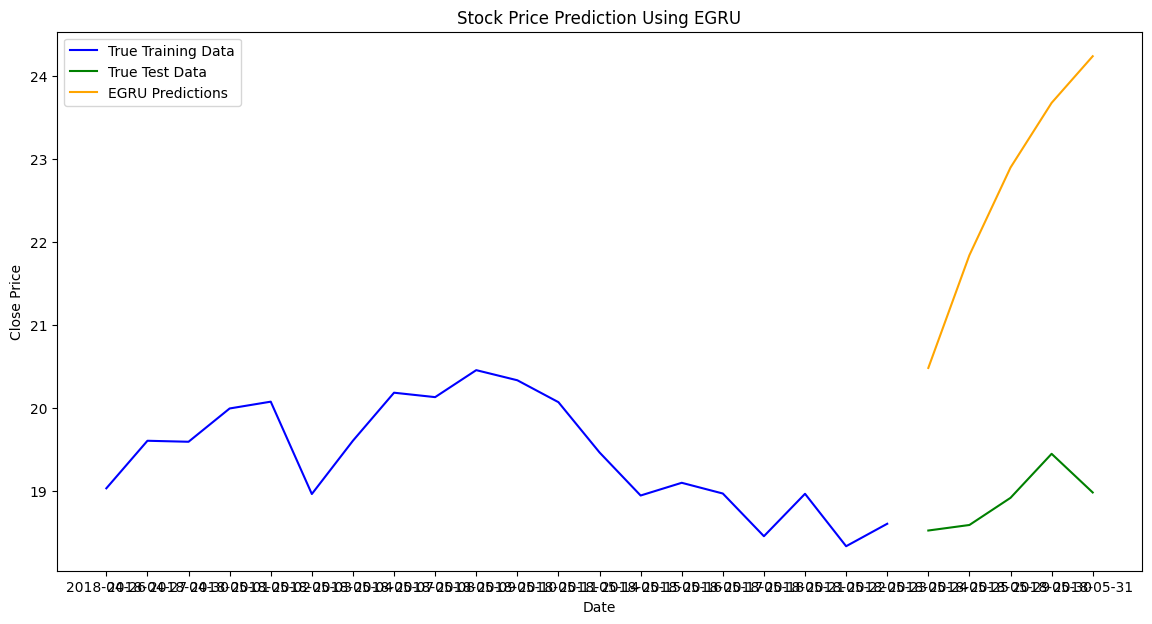

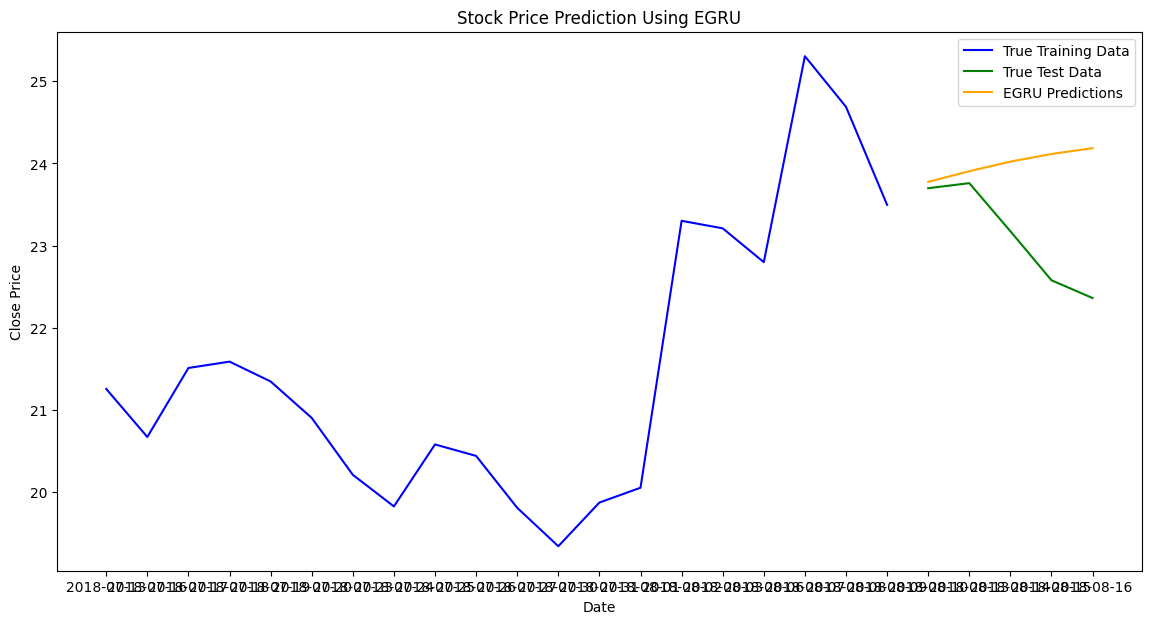

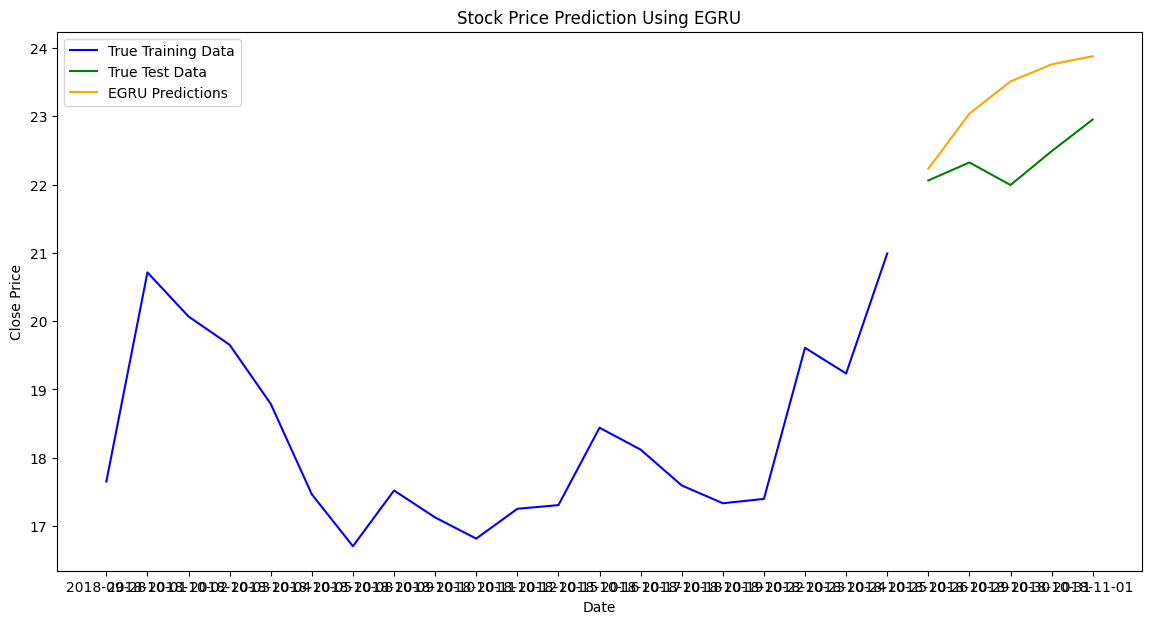

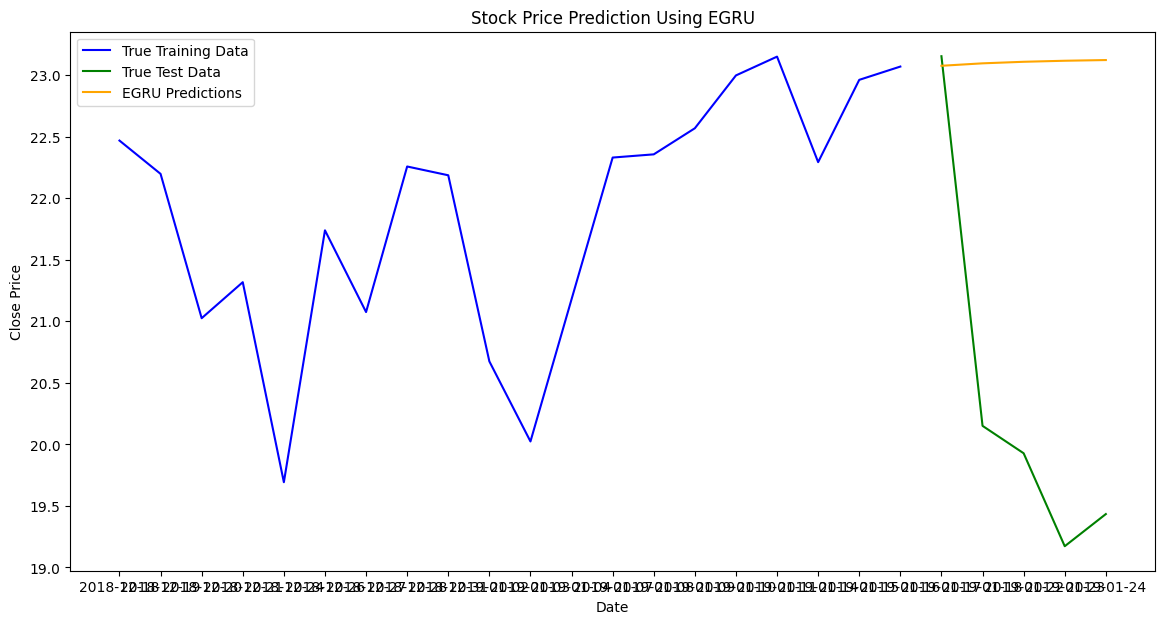

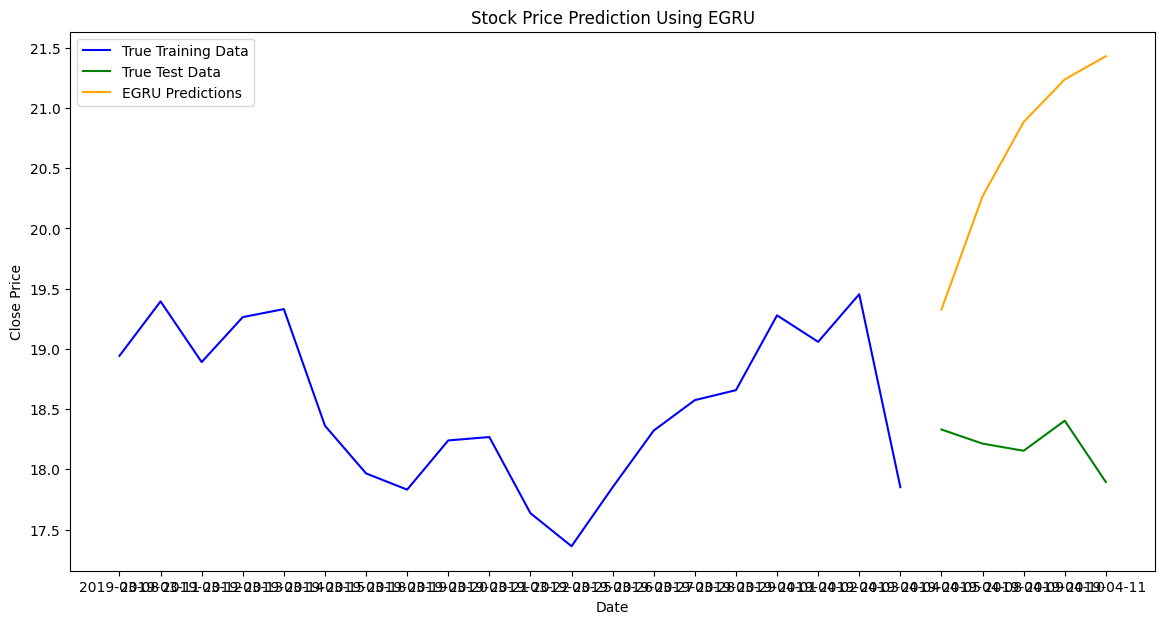

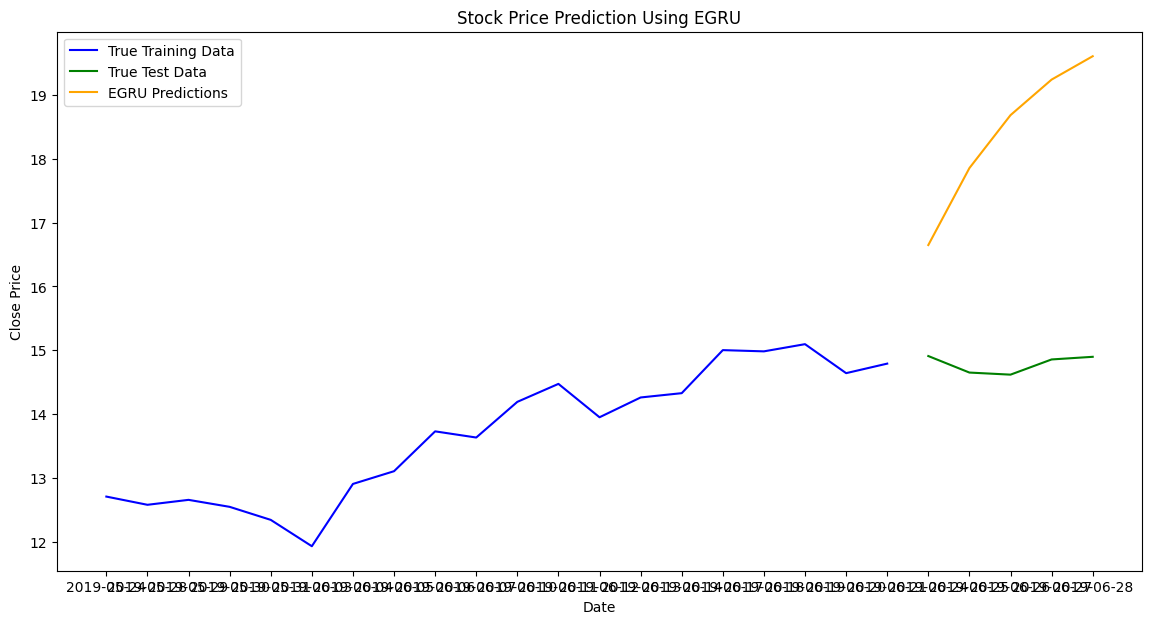

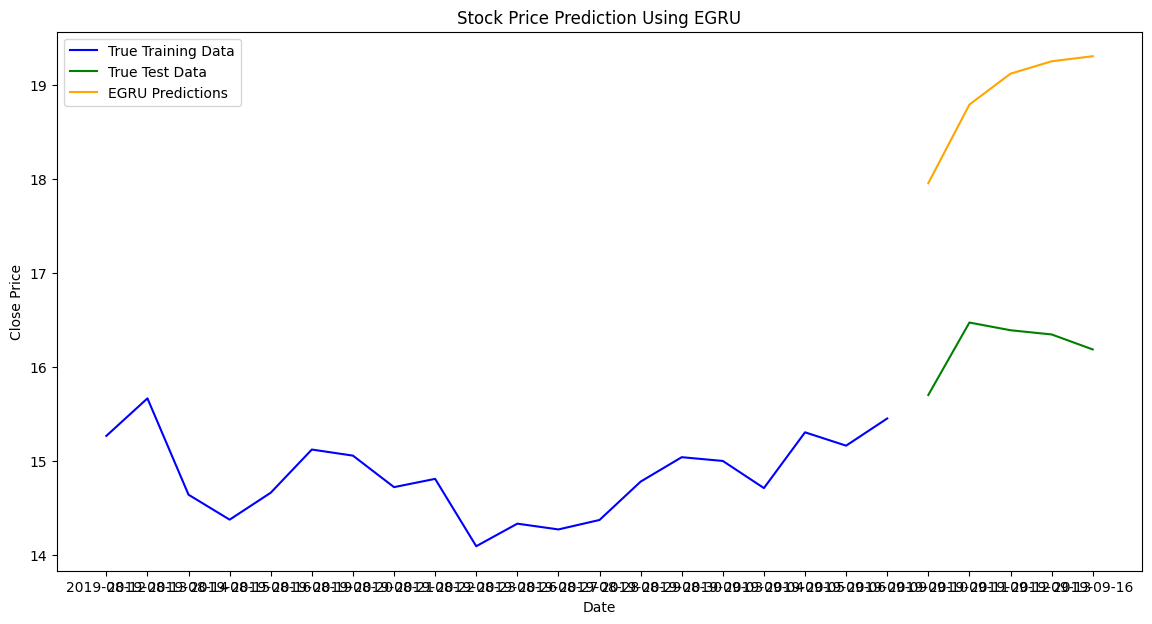

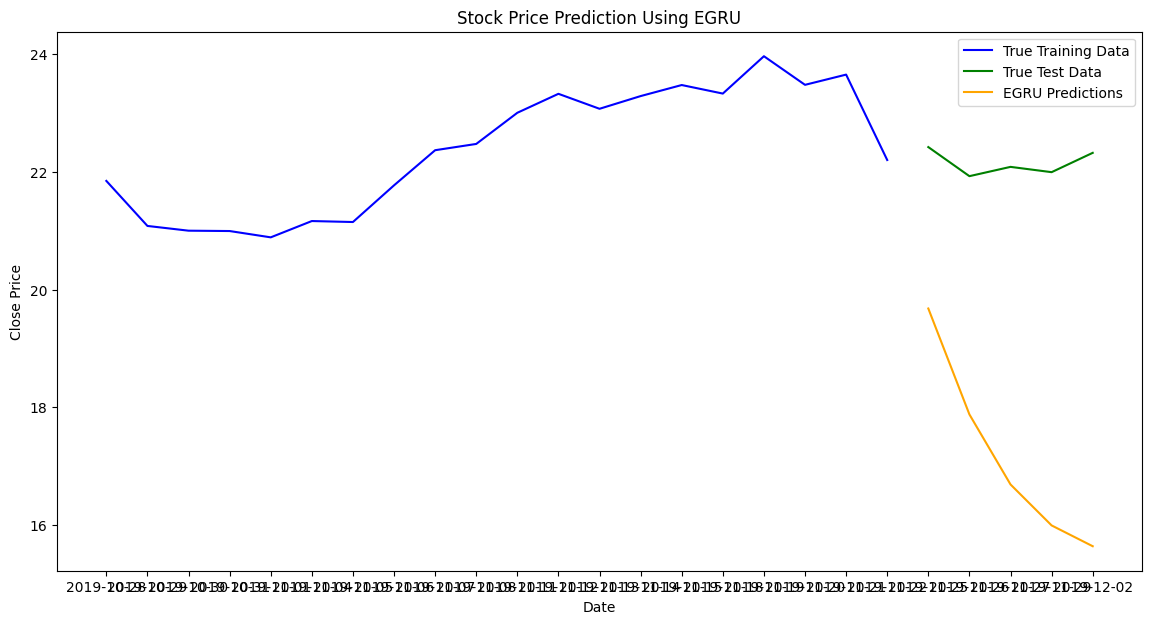

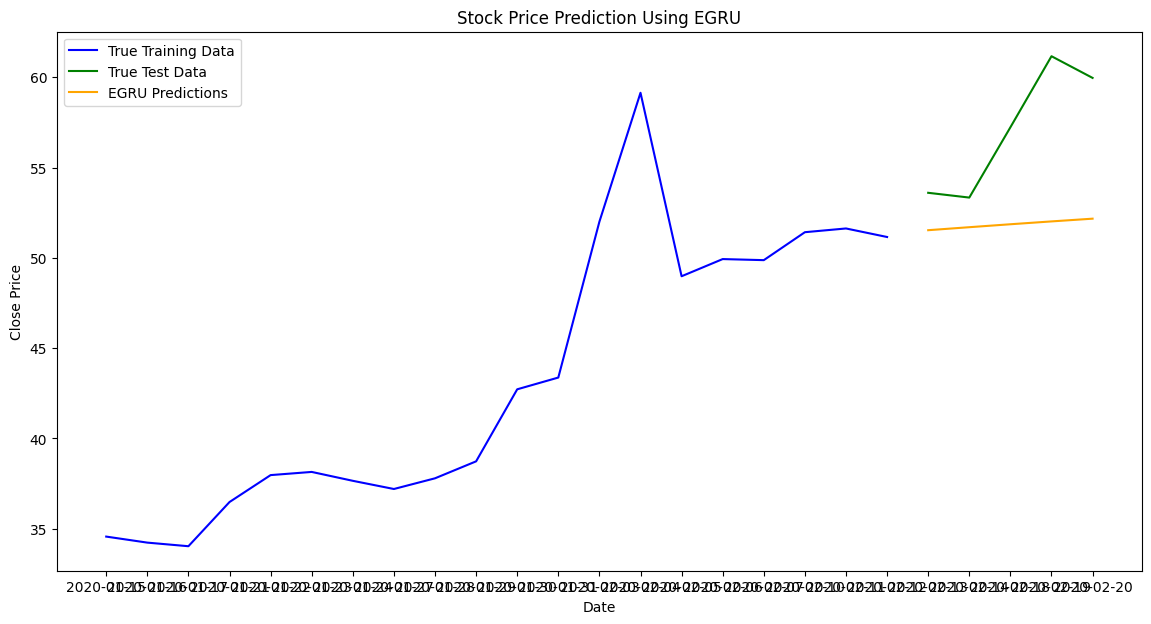

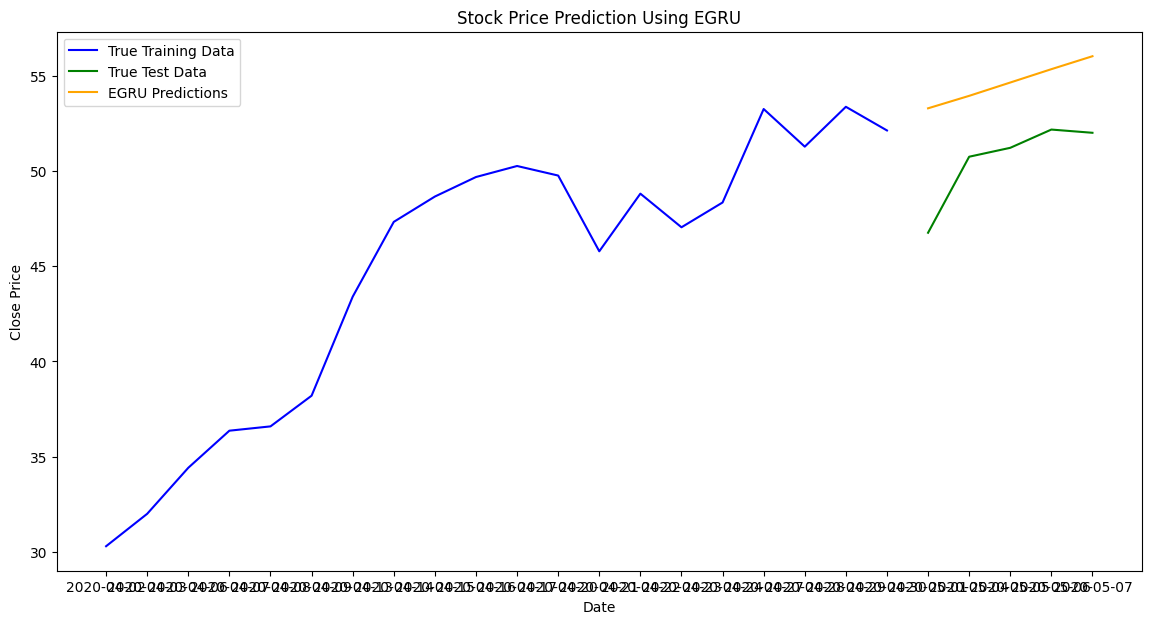

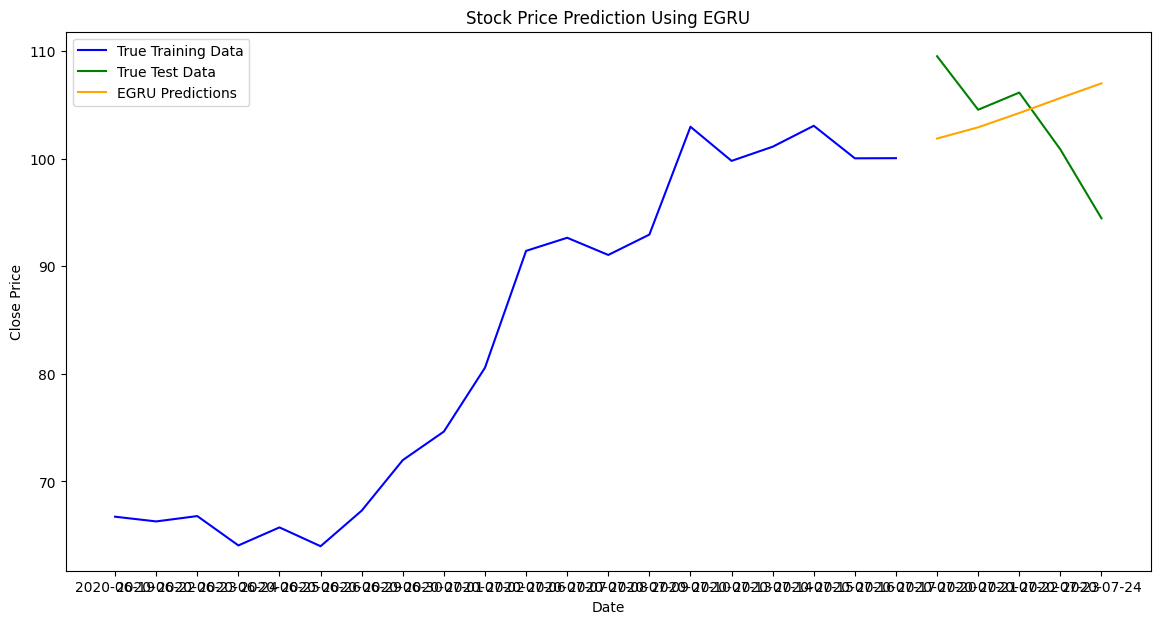

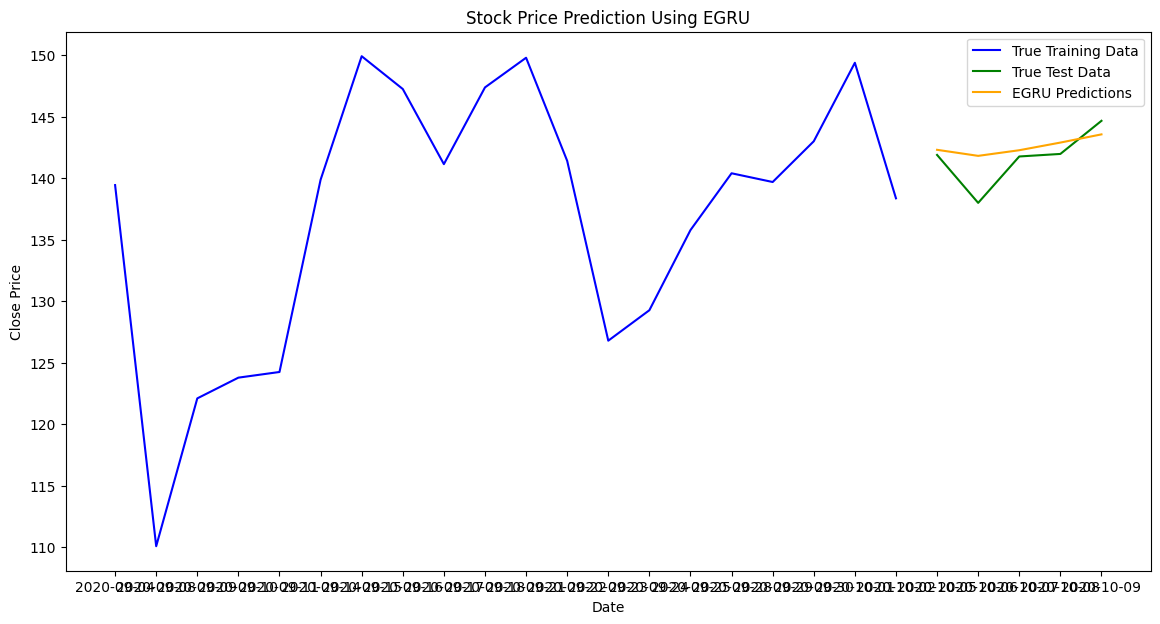

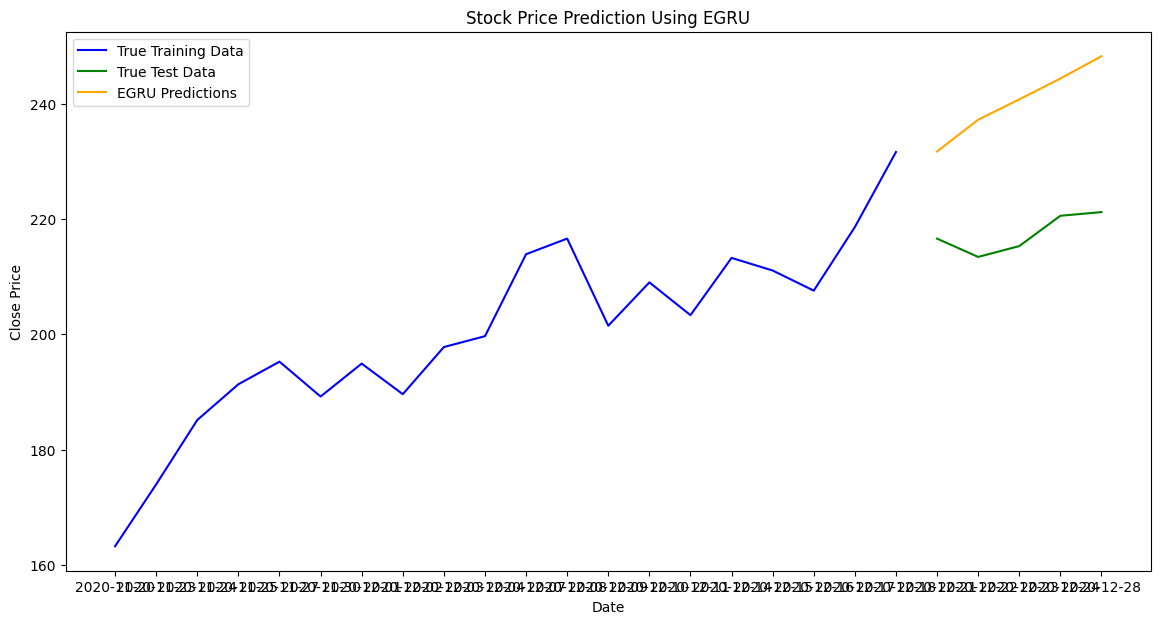

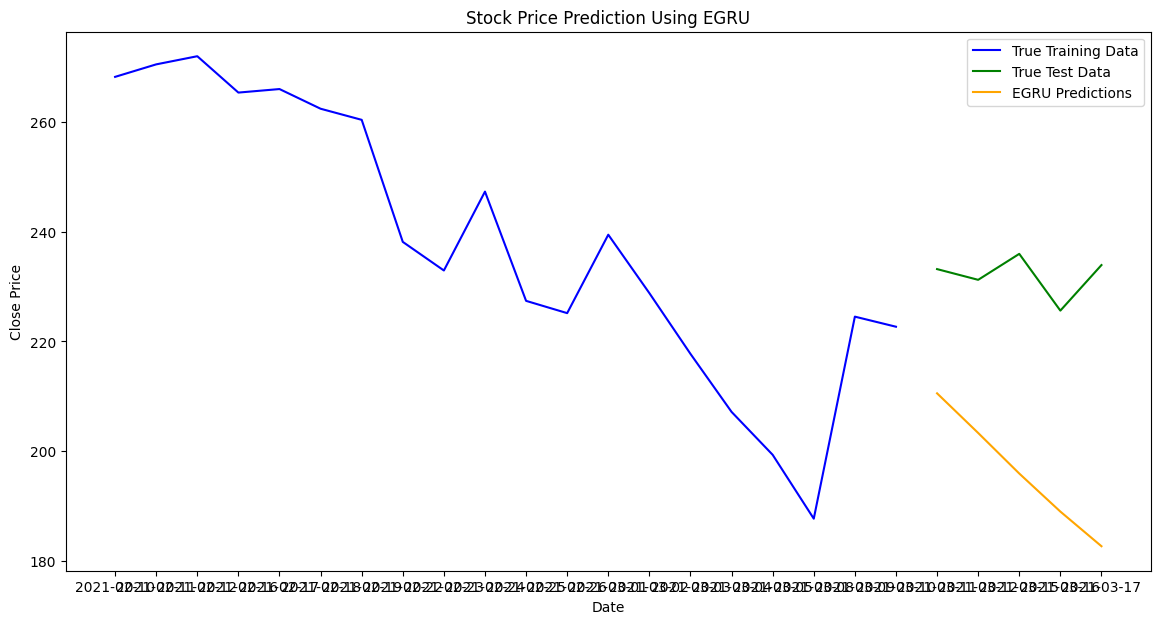

In [6]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math

class EGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.2):
        super(EGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Pass input through GRU
        out, _ = self.gru(x)
        # Take only the output from the last time step
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

def train_egru_model(p):
    n_days_to_predict = 5  # Number of days to predict
    training_period = 15  # Lookback window
    path = "TSLA.csv"  # Path to stock data

    # Load and preprocess the dataset
    headers = ["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]
    df = pd.read_csv(path, names=headers, skiprows=1)
    df.replace("null", np.nan, inplace=True)
    df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] = df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]].astype(float)
    df.set_index("Date", inplace=True)
    data = df.filter(['Close'])
    dataset = data.values

    # Normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    t = math.ceil(len(scaled_data) * p)

    # Prepare training data
    x_train, y_train = [], []
    for i in range(training_period, t):
        x_train.append(scaled_data[i - training_period:i, 0])
        y_train.append(scaled_data[i, 0])
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Convert to PyTorch tensors
    x_train = torch.tensor(x_train, dtype=torch.float32).unsqueeze(2)  # Add feature dimension
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    # Define model, loss, and optimizer
    input_size = 1
    hidden_size = 50
    output_size = 1
    model = EGRU(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    epochs = 50
    batch_size = 22
    for epoch in range(epochs):
        model.train()
        for i in range(0, len(x_train), batch_size):
            x_batch = x_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

    # Test and predict
    model.eval()
    predictions = []
    x_test = torch.tensor(scaled_data[-training_period+t:t].reshape(1, -1, 1), dtype=torch.float32)

    with torch.no_grad():
        for _ in range(n_days_to_predict):
            pred = model(x_test)  # Shape: (batch_size, output_size)
            pred_rescaled = scaler.inverse_transform(pred.numpy())  # Rescale for plotting
            predictions.append(pred_rescaled[0, 0])

            # Update x_test for the next prediction
            pred = pred.unsqueeze(2)  # Add the feature dimension
            x_test = torch.cat((x_test[:, 1:, :], pred), dim=1)  # Concatenate along the time axis

    # Plot results
    plt.figure(figsize=(14, 7))
    plt.plot(data.index[t-20:t], scaler.inverse_transform(scaled_data[t-20:t]), label='True Training Data', color='blue')
    y_test_rescaled = scaler.inverse_transform(scaled_data[t:t+n_days_to_predict])
    plt.plot(data.index[t:t+n_days_to_predict], y_test_rescaled, label='True Test Data', color='green')
    plt.plot(data.index[t:t+n_days_to_predict], predictions, label='EGRU Predictions', color='orange')

    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Stock Price Prediction Using EGRU')
    plt.legend()
    plt.savefig(f"TSLA_pred/lstm-egru/15_5/egru_{p}.png")

# Run the training process for multiple percentages
for p in np.linspace(0.60, 0.9, 15):
    train_egru_model(p)
